# Phase 2: Scaling up with Larger Models + Larger Images

## 1. Setup & Configuration

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import random
from copy import deepcopy
import json
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import cv2

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Imports successful!')

✓ Imports successful!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Device: cuda
GPU: NVIDIA L4
Memory: 23.80 GB


In [4]:
# Configuration
NUM_CLASSES = 20

CLASS_NAMES = {
    0: 'Groove_billed_Ani', 1: 'Red_winged_Blackbird', 2: 'Rusty_Blackbird',
    3: 'Gray_Catbird', 4: 'Brandt_Cormorant', 5: 'Eastern_Towhee',
    6: 'Indigo_Bunting', 7: 'Brewer_Blackbird', 8: 'Painted_Bunting',
    9: 'Bobolink', 10: 'Lazuli_Bunting', 11: 'Yellow_headed_Blackbird',
    12: 'American_Crow', 13: 'Fish_Crow', 14: 'Brown_Creeper',
    15: 'Yellow_billed_Cuckoo', 16: 'Yellow_breasted_Chat',
    17: 'Black_billed_Cuckoo', 18: 'Gray_crowned_Rosy_Finch', 19: 'Bronzed_Cowbird'
}

CONFIG = {
    'data_dir': '/content/drive/MyDrive/data',
    'train_csv': '/content/drive/MyDrive/data/train_metadata.csv',
    'val_csv': '/content/drive/MyDrive/data/val_metadata.csv',
    'combined_csv': '/content/drive/MyDrive/data/combined_metadata.csv',
    'train_images': '/content/drive/MyDrive/data/train_images',
    'val_images': '/content/drive/MyDrive/data/val_images',
    'combined_images': '/content/drive/MyDrive/data/combined_images',
    'test_images': '/content/drive/MyDrive/data/test_images',
    'sample_submission': '/content/drive/MyDrive/data/sample_submission.csv',

    # Training params (from successful Phase 2)
    'epochs': 30,
    'lr': 5e-5,
    'weight_decay': 1e-4,
    'num_workers': 4,

    # Advanced techniques (proven to work)
    'use_mixup': True,
    'mixup_alpha': 0.2,
    'use_cutmix': True,
    'cutmix_alpha': 1.0,
    'label_smoothing': 0.1,
    'drop_path_rate': 0.1,

    # Output
    'checkpoint_dir': '/content/drive/MyDrive/ml_results/phase2b_checkpoints',
    'results_dir': '/content/drive/MyDrive/ml_results/phase2b_results',
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

## 2. Model Configurations

In [5]:
# Define all models to test
MODEL_CONFIGS = [
    # ConvNeXt Family
    {
        'name': 'convnext_tiny_288',
        'model_name': 'convnext_tiny',
        'img_size': 288,
        'batch_size': 32,
        'description': 'ConvNeXt-Tiny @ 288 (baseline upgrade)'
    },
    {
        'name': 'convnext_small_288',
        'model_name': 'convnext_small',
        'img_size': 288,
        'batch_size': 24,
        'description': 'ConvNeXt-Small @ 288 (~50M params)'
    },
    {
        'name': 'convnext_base_288',
        'model_name': 'convnext_base',
        'img_size': 288,
        'batch_size': 16,
        'description': 'ConvNeXt-Base @ 288 (~89M params)'
    },
    {
        'name': 'convnext_base_384',
        'model_name': 'convnext_base',
        'img_size': 384,
        'batch_size': 12,
        'description': 'ConvNeXt-Base @ 384 (high res)'
    },

    # EfficientNet Family
    {
        'name': 'efficientnetv2_s_288',
        'model_name': 'tf_efficientnetv2_s',
        'img_size': 288,
        'batch_size': 28,
        'description': 'EfficientNetV2-S @ 288'
    },
    {
        'name': 'efficientnetv2_m_320',
        'model_name': 'tf_efficientnetv2_m',
        'img_size': 320,
        'batch_size': 20,
        'description': 'EfficientNetV2-M @ 320'
    },

    # Vision Transformers
    {
        'name': 'vit_base_224',
        'model_name': 'vit_base_patch16_224',
        'img_size': 224,
        'batch_size': 32,
        'description': 'ViT-Base @ 224 (pure attention)'
    },
    {
        'name': 'swin_base_224',
        'model_name': 'swin_base_patch4_window7_224',
        'img_size': 224,
        'batch_size': 24,
        'description': 'Swin-Base @ 224 (hierarchical)'
    },

    # Hybrid Models (optional - comment out if too slow)
    {
        'name': 'maxvit_tiny_224',
        'model_name': 'maxvit_tiny_tf_224',
        'img_size': 224,
        'batch_size': 32,
        'description': 'MaxViT-Tiny @ 224 (hybrid CNN+ViT)'
    },
    {
        'name': 'coatnet_0_224',
        'model_name': 'coatnet_0_rw_224',
        'img_size': 224,
        'batch_size': 32,
        'description': 'CoAtNet-0 @ 224 (conv + attention)'
    },
]

print(f"Configured {len(MODEL_CONFIGS)} model variants to test:")
for i, cfg in enumerate(MODEL_CONFIGS, 1):
    print(f"  {i}. {cfg['name']}: {cfg['description']}")

Configured 10 model variants to test:
  1. convnext_tiny_288: ConvNeXt-Tiny @ 288 (baseline upgrade)
  2. convnext_small_288: ConvNeXt-Small @ 288 (~50M params)
  3. convnext_base_288: ConvNeXt-Base @ 288 (~89M params)
  4. convnext_base_384: ConvNeXt-Base @ 384 (high res)
  5. efficientnetv2_s_288: EfficientNetV2-S @ 288
  6. efficientnetv2_m_320: EfficientNetV2-M @ 320
  7. vit_base_224: ViT-Base @ 224 (pure attention)
  8. swin_base_224: Swin-Base @ 224 (hierarchical)
  9. maxvit_tiny_224: MaxViT-Tiny @ 224 (hybrid CNN+ViT)
  10. coatnet_0_224: CoAtNet-0 @ 224 (conv + attention)


## 3. Data Loading (Same as Phase 2)

In [6]:
# Load data
train_df = pd.read_csv(CONFIG['train_csv'])
val_df = pd.read_csv(CONFIG['val_csv'])
combined_df = pd.read_csv(CONFIG['combined_csv'])

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Combined samples: {len(combined_df):,}")

Training samples: 1,082
Validation samples: 103
Combined samples: 1,185


In [7]:
class BirdDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['path'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, row['class_idx']

print('✓ Dataset class defined')

✓ Dataset class defined


In [8]:
def get_transforms(img_size=224, mode='train'):
    """Advanced augmentation from Phase 2"""
    if mode == 'train':
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.15,
                scale_limit=0.15,
                rotate_limit=30,
                p=0.5
            ),
            A.OneOf([
                A.Perspective(p=1),
                A.ElasticTransform(p=1),
            ], p=0.3),
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.3,
                    contrast_limit=0.3,
                    p=1
                ),
                A.HueSaturationValue(
                    hue_shift_limit=20,
                    sat_shift_limit=30,
                    val_shift_limit=20,
                    p=1
                ),
                A.ColorJitter(p=1),
            ], p=0.5),
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=1),
                A.GaussNoise(var_limit=(10.0, 50.0), p=1),
                A.MotionBlur(blur_limit=5, p=1),
            ], p=0.3),
            A.OneOf([
                A.CoarseDropout(
                    max_holes=8,
                    max_height=img_size//8,
                    max_width=img_size//8,
                    min_holes=1,
                    fill_value=0,
                    p=1
                ),
                A.GridDropout(ratio=0.2, p=1),
            ], p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])

print('✓ Transform functions defined')

✓ Transform functions defined


## 4. Training Components (From Phase 2)

In [9]:
# MixUp and CutMix
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    _, _, H, W = x.shape
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def mixed_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        loss = -log_preds.sum(dim=-1).mean()
        nll = F.nll_loss(log_preds, target, reduction='mean')
        return self.epsilon * loss / n_classes + (1 - self.epsilon) * nll

print('✓ MixUp, CutMix, and Label Smoothing defined')

✓ MixUp, CutMix, and Label Smoothing defined


In [10]:
def create_model(model_name, num_classes=NUM_CLASSES, drop_path_rate=0.1):
    """Create model with drop path regularization"""
    try:
        model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=num_classes,
            drop_path_rate=drop_path_rate
        )
    except:
        # Some models don't support drop_path_rate
        model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=num_classes
        )
    return model

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print('✓ Model creation functions defined')

✓ Model creation functions defined


In [11]:
def train_epoch(model, loader, criterion, optimizer, device, config):
    """Train one epoch with MixUp/CutMix"""
    model.train()
    running_loss = 0.0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Apply MixUp or CutMix
        r = np.random.rand()
        if config['use_mixup'] and r < 0.4:
            images, labels_a, labels_b, lam = mixup_data(
                images, labels, config['mixup_alpha']
            )
            use_mixed = True
        elif config['use_cutmix'] and r < 0.8:
            images, labels_a, labels_b, lam = cutmix_data(
                images, labels, config['cutmix_alpha']
            )
            use_mixed = True
        else:
            use_mixed = False

        optimizer.zero_grad()
        outputs = model(images)

        if use_mixed:
            loss = mixed_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print('✓ Training functions defined')

✓ Training functions defined


## 5. Main Training Loop for Each Model

In [12]:
def train_model(model_config, epochs=30):
    """
    Train a single model configuration
    """
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_config['name']}")
    print(f"Description: {model_config['description']}")
    print(f"Image Size: {model_config['img_size']}")
    print(f"Batch Size: {model_config['batch_size']}")
    print(f"{'='*80}")

    # Create dataloaders for this model's image size
    train_dataset = BirdDataset(
        train_df,
        CONFIG['train_images'],
        get_transforms(model_config['img_size'], 'train')
    )

    val_dataset = BirdDataset(
        val_df,
        CONFIG['val_images'],
        get_transforms(model_config['img_size'], 'val')
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=model_config['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=model_config['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    # Create model
    model = create_model(
        model_config['model_name'],
        num_classes=NUM_CLASSES,
        drop_path_rate=CONFIG['drop_path_rate']
    )

    total_params, trainable_params = count_parameters(model)
    print(f"\nModel Parameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")

    model = model.to(device)

    # Setup training
    criterion = LabelSmoothingCrossEntropy(epsilon=CONFIG['label_smoothing'])
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['lr'],
        weight_decay=CONFIG['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs,
        eta_min=1e-6
    )

    # Training loop
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}
    patience_counter = 0
    patience = 8

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, CONFIG)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Track
        epoch_time = time.time() - epoch_start
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_times'].append(epoch_time)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Time: {epoch_time:.1f}s, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'model_config': model_config
            }
            torch.save(
                checkpoint,
                os.path.join(CONFIG['checkpoint_dir'], f"{model_config['name']}_best.pth")
            )
            print(f"✓ Best model saved: {val_acc:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    total_time = time.time() - start_time

    print(f"\n{'='*80}")
    print(f"Training Complete: {model_config['name']}")
    print(f"Best Val Acc: {best_val_acc:.4f}")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"Avg Time/Epoch: {np.mean(history['epoch_times']):.1f}s")
    print(f"{'='*80}")

    # Cleanup
    del model, optimizer, scheduler, train_loader, val_loader
    torch.cuda.empty_cache()

    return {
        'name': model_config['name'],
        'description': model_config['description'],
        'img_size': model_config['img_size'],
        'batch_size': model_config['batch_size'],
        'best_val_acc': best_val_acc,
        'total_time': total_time,
        'avg_epoch_time': np.mean(history['epoch_times']),
        'history': history,
        'total_params': total_params,
        'trainable_params': trainable_params
    }

In [13]:
def train_model_complete(model_config, epochs=30):
    """
    Train a single model configuration
    """
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_config['name']}")
    print(f"Description: {model_config['description']}")
    print(f"Image Size: {model_config['img_size']}")
    print(f"Batch Size: {model_config['batch_size']}")
    print(f"{'='*80}")

    # Create dataloaders for this model's image size
    train_dataset = BirdDataset(
        train_df,
        CONFIG['combined_images'],
        get_transforms(model_config['img_size'], 'train')
    )

    val_dataset = BirdDataset(
        val_df,
        CONFIG['val_images'],
        get_transforms(model_config['img_size'], 'val')
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=model_config['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=model_config['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    # Create model
    model = create_model(
        model_config['model_name'],
        num_classes=NUM_CLASSES,
        drop_path_rate=CONFIG['drop_path_rate']
    )

    total_params, trainable_params = count_parameters(model)
    print(f"\nModel Parameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")

    model = model.to(device)

    # Setup training
    criterion = LabelSmoothingCrossEntropy(epsilon=CONFIG['label_smoothing'])
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['lr'],
        weight_decay=CONFIG['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs,
        eta_min=1e-6
    )

    # Training loop
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}
    patience_counter = 0
    patience = 8

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, CONFIG)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Track
        epoch_time = time.time() - epoch_start
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_times'].append(epoch_time)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Time: {epoch_time:.1f}s, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'model_config': model_config
            }
            torch.save(
                checkpoint,
                os.path.join(CONFIG['checkpoint_dir'], f"{model_config['name']}_best.pth")
            )
            print(f"✓ Best model saved: {val_acc:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    total_time = time.time() - start_time

    print(f"\n{'='*80}")
    print(f"Training Complete: {model_config['name']}")
    print(f"Best Val Acc: {best_val_acc:.4f}")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"Avg Time/Epoch: {np.mean(history['epoch_times']):.1f}s")
    print(f"{'='*80}")

    # Cleanup
    del model, optimizer, scheduler, train_loader, val_loader
    torch.cuda.empty_cache()

    return {
        'name': model_config['name'],
        'description': model_config['description'],
        'img_size': model_config['img_size'],
        'batch_size': model_config['batch_size'],
        'best_val_acc': best_val_acc,
        'total_time': total_time,
        'avg_epoch_time': np.mean(history['epoch_times']),
        'history': history,
        'total_params': total_params,
        'trainable_params': trainable_params
    }

## 6. Train All Models

In [14]:
# Select which models to train
# Comment out models you want to skip

MODELS_TO_TRAIN = [
    # MODEL_CONFIGS[0],  # ConvNeXt-Tiny @ 288
    # MODEL_CONFIGS[1],  # ConvNeXt-Small @ 288
    # MODEL_CONFIGS[2],  # ConvNeXt-Base @ 288
    MODEL_CONFIGS[3],  # ConvNeXt-Base @ 384
    # MODEL_CONFIGS[4],  # EfficientNetV2-S @ 288
    # MODEL_CONFIGS[5],  # EfficientNetV2-M @ 320
    MODEL_CONFIGS[6],  # ViT-Base @ 224
    MODEL_CONFIGS[7],  # Swin-Base @ 224
    # MODEL_CONFIGS[8],  # MaxViT - comment out if too slow
    # MODEL_CONFIGS[9],  # CoAtNet - comment out if too slow
]

print(f"Will train {len(MODELS_TO_TRAIN)} models")

Will train 3 models


In [15]:
# Train all selected models
all_results = []

for i, model_config in enumerate(MODELS_TO_TRAIN, 1):
    print(f"\n\n{'#'*80}")
    print(f"MODEL {i}/{len(MODELS_TO_TRAIN)}")
    print(f"{'#'*80}")

    result = train_model(model_config, epochs=CONFIG['epochs'])
    all_results.append(result)

    print(f"\n✓ Completed {i}/{len(MODELS_TO_TRAIN)} models")
    print(f"   Best so far: {max([r['best_val_acc'] for r in all_results]):.4f}")

print(f"\n\n{'='*80}")
print("ALL MODELS TRAINED!")
print(f"{'='*80}")



################################################################################
MODEL 1/3
################################################################################

TRAINING: convnext_base_384
Description: ConvNeXt-Base @ 384 (high res)
Image Size: 384
Batch Size: 12


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]


Model Parameters:
  Total: 87,586,964
  Trainable: 87,586,964

Epoch 1/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 2.2366
Val Loss: 1.0066, Val Acc: 0.8641
Time: 249.2s, LR: 0.000050
✓ Best model saved: 0.8641

Epoch 2/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.4556
Val Loss: 0.8186, Val Acc: 0.9223
Time: 76.8s, LR: 0.000049
✓ Best model saved: 0.9223

Epoch 3/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.2529
Val Loss: 0.7620, Val Acc: 0.9320
Time: 96.8s, LR: 0.000049
✓ Best model saved: 0.9320

Epoch 4/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.2735
Val Loss: 0.7456, Val Acc: 0.9320
Time: 177.5s, LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.2009
Val Loss: 0.7127, Val Acc: 0.9417
Time: 96.7s, LR: 0.000047
✓ Best model saved: 0.9417

Epoch 6/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1004
Val Loss: 0.7424, Val Acc: 0.9320
Time: 97.6s, LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1413
Val Loss: 0.7160, Val Acc: 0.9320
Time: 96.9s, LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1545
Val Loss: 0.7393, Val Acc: 0.9320
Time: 96.4s, LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0804
Val Loss: 0.7144, Val Acc: 0.9417
Time: 96.4s, LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0579
Val Loss: 0.7030, Val Acc: 0.9515
Time: 96.9s, LR: 0.000038
✓ Best model saved: 0.9515

Epoch 11/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0094
Val Loss: 0.7329, Val Acc: 0.9223
Time: 97.8s, LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0864
Val Loss: 0.7094, Val Acc: 0.9515
Time: 96.4s, LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0318
Val Loss: 0.7075, Val Acc: 0.9417
Time: 76.8s, LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0073
Val Loss: 0.6766, Val Acc: 0.9709
Time: 96.5s, LR: 0.000028
✓ Best model saved: 0.9709

Epoch 15/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0116
Val Loss: 0.7003, Val Acc: 0.9515
Time: 96.7s, LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9604
Val Loss: 0.6800, Val Acc: 0.9612
Time: 96.4s, LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0836
Val Loss: 0.7129, Val Acc: 0.9417
Time: 96.6s, LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>    self._shutdown_workers()
Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>    if w.is_alive():    self._shutdown_workers()

Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    sel

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0380
Val Loss: 0.6882, Val Acc: 0.9612
Time: 76.8s, LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0202
Val Loss: 0.6901, Val Acc: 0.9709
Time: 96.5s, LR: 0.000016

Epoch 20/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0274
Val Loss: 0.7038, Val Acc: 0.9515
Time: 96.4s, LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9728
Val Loss: 0.6901, Val Acc: 0.9709
Time: 96.5s, LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9962
Val Loss: 0.6903, Val Acc: 0.9709
Time: 96.5s, LR: 0.000009

Early stopping at epoch 22

Training Complete: convnext_base_384
Best Val Acc: 0.9709
Total Time: 38.42 minutes
Avg Time/Epoch: 104.6s

✓ Completed 1/3 models
   Best so far: 0.9709


################################################################################
MODEL 2/3
################################################################################

TRAINING: vit_base_224
Description: ViT-Base @ 224 (pure attention)
Image Size: 224
Batch Size: 32


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Model Parameters:
  Total: 85,814,036
  Trainable: 85,814,036

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.5924
Val Loss: 1.3037, Val Acc: 0.7670
Time: 18.3s, LR: 0.000050
✓ Best model saved: 0.7670

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.7515
Val Loss: 1.0945, Val Acc: 0.8544
Time: 18.2s, LR: 0.000049
✓ Best model saved: 0.8544

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4411
Val Loss: 0.9913, Val Acc: 0.8544
Time: 22.7s, LR: 0.000049

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       Exception ignored in: if w.is_alive(): <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
^
 ^Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", 

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

     ^self._shutdown_workers() ^ 
^^^^^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^^    
^if w.is_alive():  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

^     ^assert self._parent_pid == os.getpid(), 'can only test a child process' ^
 ^  ^  ^  
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^     assert self._parent_pid == os.getpid(), 'can only test a child process' ^
 ^   ^   ^ ^^^ ^^ ^^ ^^ ^^ Exception ignored in: ^^ ^^ ^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^^
Traceback (most recent call last):
^^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^ ^^     ^^self._shutdown_workers() ^^
 ^^  File "/usr/loc

Train Loss: 1.6175
Val Loss: 0.9572, Val Acc: 0.8641
Time: 88.6s, LR: 0.000048
✓ Best model saved: 0.8641

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4064
Val Loss: 0.9910, Val Acc: 0.8738
Time: 22.7s, LR: 0.000047
✓ Best model saved: 0.8738

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3672
Val Loss: 0.9321, Val Acc: 0.8835
Time: 22.8s, LR: 0.000045
✓ Best model saved: 0.8835

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4603
Val Loss: 0.8880, Val Acc: 0.9223
Time: 22.2s, LR: 0.000044
✓ Best model saved: 0.9223

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4435
Val Loss: 0.9593, Val Acc: 0.8544
Time: 21.5s, LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20> 
     Traceback (most recent call last):
if w.is_alive():   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3416
Val Loss: 0.9313, Val Acc: 0.8738
Time: 179.5s, LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4170
Val Loss: 0.8773, Val Acc: 0.8932
Time: 18.5s, LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2372
Val Loss: 0.9080, Val Acc: 0.8738
Time: 18.1s, LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2021
Val Loss: 0.8687, Val Acc: 0.9320
Time: 18.1s, LR: 0.000033
✓ Best model saved: 0.9320

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>     


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

if w.is_alive(): Traceback (most recent call last):

^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 ^     ^ self._shutdown_workers()^ 
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^     ^ if w.is_alive():^^
^^^ ^^ ^^ ^^ 
^   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^ ^     assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^^ ^
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^     ^assert self._parent_pid == os.getpid(), 'can only test a child process' ^
^  ^  ^  ^  ^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^     ^ assert self._parent_pid == os.getpid(), 'can only test a child process'^ 
^  ^  ^^ ^^ ^Exception ignored in: ^  ^^^ ^^ ^ ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20> ^^
 ^^Traceback (most r

Train Loss: 1.3550
Val Loss: 0.8810, Val Acc: 0.9126
Time: 182.8s, LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3340
Val Loss: 0.8965, Val Acc: 0.9029
Time: 17.8s, LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0347
Val Loss: 0.8715, Val Acc: 0.9223
Time: 18.0s, LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3541
Val Loss: 0.8684, Val Acc: 0.8835
Time: 18.0s, LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^Exception ignored in: 
^ ^ ^ ^

Train Loss: 1.2650
Val Loss: 0.8986, Val Acc: 0.9223
Time: 18.9s, LR: 0.000020

Epoch 18/30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     Exception ignored in:  if w.is_alive():

Training:   0%|          | 0/34 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>^

^ Traceback (most recent call last):
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^     ^ self._shutdown_workers() 
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^ ^    ^^if w.is_alive():^^
^ ^^

Validation:   0%|          | 0/4 [00:43<?, ?it/s]

 
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^ ^     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^ 
^  ^^ ^^ 
^   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^     ^ assert self._parent_pid == os.getpid(), 'can only test a child process'^ 
^  Exception ignored in: ^  ^  ^  ^^ ^^ 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>^   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

^     Traceback (most recent call last):
^ assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^ 
^      ^^self._shutdown_workers() ^^ 
^^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^ ^ ^    ^ if w.is_alive():^^ 
^^ ^ ^  ^^ ^ ^^ ^^^^ ^^^ ^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Train Loss: 1.2558
Val Loss: 0.8611, Val Acc: 0.9126
Time: 165.6s, LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2421
Val Loss: 0.8258, Val Acc: 0.9223
Time: 18.9s, LR: 0.000016

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1861
Val Loss: 0.8253, Val Acc: 0.9320
Time: 18.8s, LR: 0.000013

Early stopping at epoch 20

Training Complete: vit_base_224
Best Val Acc: 0.9320
Total Time: 15.63 minutes
Avg Time/Epoch: 46.5s

✓ Completed 2/3 models
   Best so far: 0.9709


################################################################################
MODEL 3/3
################################################################################

TRAINING: swin_base_224
Description: Swin-Base @ 224 (hierarchical)
Image Size: 224
Batch Size: 24


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]


Model Parameters:
  Total: 86,763,724
  Trainable: 86,763,724

Epoch 1/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4190
Val Loss: 0.9325, Val Acc: 0.9029
Time: 23.1s, LR: 0.000050
✓ Best model saved: 0.9029

Epoch 2/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.5943
Val Loss: 0.8595, Val Acc: 0.8932
Time: 27.2s, LR: 0.000049

Epoch 3/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3695
Val Loss: 0.8282, Val Acc: 0.9320
Time: 42.6s, LR: 0.000049
✓ Best model saved: 0.9320

Epoch 4/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3335
Val Loss: 0.8204, Val Acc: 0.9320
Time: 47.2s, LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.2845
Val Loss: 0.8150, Val Acc: 0.9223
Time: 23.1s, LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1265
Val Loss: 0.7658, Val Acc: 0.9126
Time: 22.8s, LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2150
Val Loss: 0.7650, Val Acc: 0.9417
Time: 62.5s, LR: 0.000044
✓ Best model saved: 0.9417

Epoch 8/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0294
Val Loss: 0.7887, Val Acc: 0.9126
Time: 44.0s, LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0687
Val Loss: 0.7637, Val Acc: 0.9223
Time: 42.6s, LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0884
Val Loss: 0.7647, Val Acc: 0.9417
Time: 22.9s, LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1616
Val Loss: 0.8024, Val Acc: 0.9126
Time: 82.9s, LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1775
Val Loss: 0.7404, Val Acc: 0.9320
Time: 42.5s, LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.1863
Val Loss: 0.7346, Val Acc: 0.9223
Time: 62.8s, LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9922
Val Loss: 0.7734, Val Acc: 0.8932
Time: 22.9s, LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0716
Val Loss: 0.7751, Val Acc: 0.9126
Time: 62.7s, LR: 0.000026

Early stopping at epoch 15

Training Complete: swin_base_224
Best Val Acc: 0.9417
Total Time: 10.72 minutes
Avg Time/Epoch: 42.1s

✓ Completed 3/3 models
   Best so far: 0.9709


ALL MODELS TRAINED!


## 7. Results Analysis & Comparison

In [16]:
# Create results dataframe
results_df = pd.DataFrame([
    {
        'Model': r['name'],
        'Description': r['description'],
        'Image Size': r['img_size'],
        'Batch Size': r['batch_size'],
        'Best Val Acc': f"{r['best_val_acc']:.4f}",
        'Total Time (min)': f"{r['total_time']/60:.1f}",
        'Avg Epoch (s)': f"{r['avg_epoch_time']:.1f}",
        'Parameters (M)': f"{r['total_params']/1e6:.1f}",
    }
    for r in all_results
])

results_df = results_df.sort_values('Best Val Acc', ascending=False)

print("\n" + "="*100)
print("PHASE 2B: MODEL COMPARISON RESULTS")
print("="*100)
display(results_df)

# Save results
results_df.to_csv(
    os.path.join(CONFIG['results_dir'], 'phase2b_model_comparison.csv'),
    index=False
)
print("\n✓ Results saved to phase2b_results/phase2b_model_comparison.csv")


PHASE 2B: MODEL COMPARISON RESULTS


,Model,Description,Image Size,Batch Size,Best Val Acc,Total Time (min),Avg Epoch (s),Parameters (M)
0,convnext_base_384,ConvNeXt-Base @ 384 (high res),384,12,0.9709,38.4,104.6,87.6
2,swin_base_224,Swin-Base @ 224 (hierarchical),224,24,0.9417,10.7,42.1,86.8
1,vit_base_224,ViT-Base @ 224 (pure attention),224,32,0.9320,15.6,46.5,85.8



✓ Results saved to phase2b_results/phase2b_model_comparison.csv


In [17]:
# Train best model on COMPLETE dataset
all_results = []

for i, model_config in enumerate(MODELS_TO_TRAIN, 1):
    print(f"\n\n{'#'*80}")
    print(f"MODEL {i}/{len(MODELS_TO_TRAIN)}")
    print(f"{'#'*80}")

    result = train_model_complete(model_config, epochs=CONFIG['epochs'])
    all_results.append(result)

    print(f"\n✓ Completed {i}/{len(MODELS_TO_TRAIN)} models")
    print(f"   Best so far: {max([r['best_val_acc'] for r in all_results]):.4f}")

print(f"\n\n{'='*80}")
print("ALL MODELS TRAINED!")
print(f"{'='*80}")



################################################################################
MODEL 1/3
################################################################################

TRAINING: convnext_base_384
Description: ConvNeXt-Base @ 384 (high res)
Image Size: 384
Batch Size: 12

Model Parameters:
  Total: 87,586,964
  Trainable: 87,586,964

Epoch 1/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 2.2961
Val Loss: 0.9115, Val Acc: 0.9126
Time: 220.6s, LR: 0.000050
✓ Best model saved: 0.9126

Epoch 2/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.3466
Val Loss: 0.7979, Val Acc: 0.9223
Time: 78.5s, LR: 0.000049
✓ Best model saved: 0.9223

Epoch 3/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.3238
Val Loss: 0.8001, Val Acc: 0.9029
Time: 98.0s, LR: 0.000049

Epoch 4/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1320
Val Loss: 0.7562, Val Acc: 0.9029
Time: 97.4s, LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1343
Val Loss: 0.7558, Val Acc: 0.9223
Time: 96.9s, LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20> 
    Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0638
Val Loss: 0.7770, Val Acc: 0.9223
Time: 77.4s, LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0999
Val Loss: 0.7503, Val Acc: 0.9029
Time: 96.9s, LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0813
Val Loss: 0.7325, Val Acc: 0.9320
Time: 97.0s, LR: 0.000042
✓ Best model saved: 0.9320

Epoch 9/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0638
Val Loss: 0.7364, Val Acc: 0.9320
Time: 97.8s, LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1447
Val Loss: 0.7381, Val Acc: 0.9417
Time: 96.9s, LR: 0.000038
✓ Best model saved: 0.9417

Epoch 11/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1174
Val Loss: 0.7401, Val Acc: 0.9320
Time: 78.5s, LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1150
Val Loss: 0.7379, Val Acc: 0.9320
Time: 96.9s, LR: 0.000033

Epoch 13/30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():^
Exception ignored in: ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20> ^
 ^ 

Training:   0%|          | 0/91 [00:00<?, ?it/s]

Traceback (most recent call last):
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^ ^     self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^^^    ^^if w.is_alive():
^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^     ^ assert self._parent_pid == os.getpid(), 'can only test a child process'^ 
^  ^  ^  
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^     ^ assert self._parent_pid == os.getpid(), 'can only test a child process'^ 
^  ^  ^  ^  ^ ^^ ^^ ^^ ^^ ^
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^    ^^Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'^^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>^^ 
^^ ^Traceback (most recent call last):
^ ^  File "/usr/local/lib

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0483
Val Loss: 0.7289, Val Acc: 0.9320
Time: 577.5s, LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0015
Val Loss: 0.7409, Val Acc: 0.9320
Time: 96.8s, LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0526
Val Loss: 0.7232, Val Acc: 0.9320
Time: 96.9s, LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0663
Val Loss: 0.7269, Val Acc: 0.9320
Time: 96.8s, LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9874
Val Loss: 0.7318, Val Acc: 0.9417
Time: 96.8s, LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0222
Val Loss: 0.7179, Val Acc: 0.9320
Time: 91.1s, LR: 0.000018

Early stopping at epoch 18

Training Complete: convnext_base_384
Best Val Acc: 0.9417
Total Time: 38.86 minutes
Avg Time/Epoch: 127.1s

✓ Completed 1/3 models
   Best so far: 0.9417


################################################################################
MODEL 2/3
################################################################################

TRAINING: vit_base_224
Description: ViT-Base @ 224 (pure attention)
Image Size: 224
Batch Size: 32

Model Parameters:
  Total: 85,814,036
  Trainable: 85,814,036

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.5806
Val Loss: 1.3116, Val Acc: 0.8155
Time: 18.3s, LR: 0.000050
✓ Best model saved: 0.8155

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.8013
Val Loss: 0.9916, Val Acc: 0.8641
Time: 22.5s, LR: 0.000049
✓ Best model saved: 0.8641

Epoch 3/30


Training:   0%|          | 0/34 [01:20<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.6484
Val Loss: 0.9339, Val Acc: 0.8641
Time: 98.3s, LR: 0.000049

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.6947
Val Loss: 1.0292, Val Acc: 0.8544
Time: 18.5s, LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.6695
Val Loss: 0.9061, Val Acc: 0.8835
Time: 18.3s, LR: 0.000047
✓ Best model saved: 0.8835

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3088
Val Loss: 0.8753, Val Acc: 0.9029
Time: 22.5s, LR: 0.000045
✓ Best model saved: 0.9029

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.2905
Val Loss: 0.9044, Val Acc: 0.9223
Time: 42.4s, LR: 0.000044
✓ Best model saved: 0.9223

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3446
Val Loss: 0.9380, Val Acc: 0.8738
Time: 22.8s, LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3843
Val Loss: 0.8736, Val Acc: 0.9029
Time: 18.4s, LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2190
Val Loss: 0.8696, Val Acc: 0.9126
Time: 18.3s, LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1858
Val Loss: 0.8750, Val Acc: 0.8641
Time: 18.1s, LR: 0.000035

Epoch 12/30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Training:   0%|          | 0/34 [00:01<?, ?it/s]

can only test a child process


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1230
Val Loss: 0.8516, Val Acc: 0.9223
Time: 19.7s, LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1173
Val Loss: 0.8552, Val Acc: 0.9223
Time: 18.7s, LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3756
Val Loss: 0.8476, Val Acc: 0.9126
Time: 18.5s, LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3070
Val Loss: 0.9438, Val Acc: 0.8835
Time: 18.3s, LR: 0.000026

Early stopping at epoch 15

Training Complete: vit_base_224
Best Val Acc: 0.9223
Total Time: 6.62 minutes
Avg Time/Epoch: 26.2s

✓ Completed 2/3 models
   Best so far: 0.9417


################################################################################
MODEL 3/3
################################################################################

TRAINING: swin_base_224
Description: Swin-Base @ 224 (hierarchical)
Image Size: 224
Batch Size: 24

Model Parameters:
  Total: 86,763,724
  Trainable: 86,763,724

Epoch 1/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4516
Val Loss: 0.9567, Val Acc: 0.8738
Time: 23.2s, LR: 0.000050
✓ Best model saved: 0.8738

Epoch 2/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.6931
Val Loss: 0.8770, Val Acc: 0.8932
Time: 27.0s, LR: 0.000049
✓ Best model saved: 0.8932

Epoch 3/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2850
Val Loss: 0.8177, Val Acc: 0.9126
Time: 23.3s, LR: 0.000049
✓ Best model saved: 0.9126

Epoch 4/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3634
Val Loss: 0.7725, Val Acc: 0.9320
Time: 63.8s, LR: 0.000048
✓ Best model saved: 0.9320

Epoch 5/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2121
Val Loss: 0.7700, Val Acc: 0.9126
Time: 43.8s, LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2210
Val Loss: 0.7553, Val Acc: 0.9417
Time: 42.8s, LR: 0.000045
✓ Best model saved: 0.9417

Epoch 7/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2698
Val Loss: 0.7734, Val Acc: 0.9223
Time: 47.0s, LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.1041
Val Loss: 0.8096, Val Acc: 0.8932
Time: 62.9s, LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1513
Val Loss: 0.7752, Val Acc: 0.9320
Time: 22.8s, LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1081
Val Loss: 0.7670, Val Acc: 0.9223
Time: 62.7s, LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0798
Val Loss: 0.7360, Val Acc: 0.9612
Time: 42.5s, LR: 0.000035
✓ Best model saved: 0.9612

Epoch 12/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0997
Val Loss: 0.7479, Val Acc: 0.9417
Time: 46.9s, LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()Exception ignored in:  
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      if w.is_alive():Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1

Train Loss: 1.0575
Val Loss: 0.7607, Val Acc: 0.9223
Time: 23.0s, LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0653
Val Loss: 0.7823, Val Acc: 0.9320
Time: 23.4s, LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0623
Val Loss: 0.7391, Val Acc: 0.9417
Time: 42.2s, LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0622
Val Loss: 0.7642, Val Acc: 0.9320
Time: 42.6s, LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      Exception ignored in: ^if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>^

^ Traceback (most recent call last):
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py",

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

^ 
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^^^    ^if w.is_alive():^
^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^     ^ ^ ^assert self._parent_pid == os.getpid(), 'can only test a child process' ^
 ^  ^  ^ ^
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^    ^ assert self._parent_pid == os.getpid(), 'can only test a child process'^ 
^  ^  ^   ^ ^^ ^^ ^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^     ^assert self._parent_pid == os.getpid(), 'can only test a child process' ^
 Exception ignored in: ^  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>^ ^
 ^^ Traceback (most recent call last):
^^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^ ^^     ^^self._shutdown_workers() ^^
 ^^  File "/usr/local/lib/python3.12/dist-package

Train Loss: 1.0594
Val Loss: 0.7668, Val Acc: 0.9223
Time: 23.1s, LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1172
Val Loss: 0.7248, Val Acc: 0.9515
Time: 22.8s, LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

Exception ignored in:      <function _MultiProcessingDataLoaderIter.__del__ at 0x7c44573ebe20> if w.is_alive():
 
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0428
Val Loss: 0.7370, Val Acc: 0.9417
Time: 47.6s, LR: 0.000016

Early stopping at epoch 19

Training Complete: swin_base_224
Best Val Acc: 0.9612
Total Time: 13.30 minutes
Avg Time/Epoch: 38.6s

✓ Completed 3/3 models
   Best so far: 0.9612


ALL MODELS TRAINED!


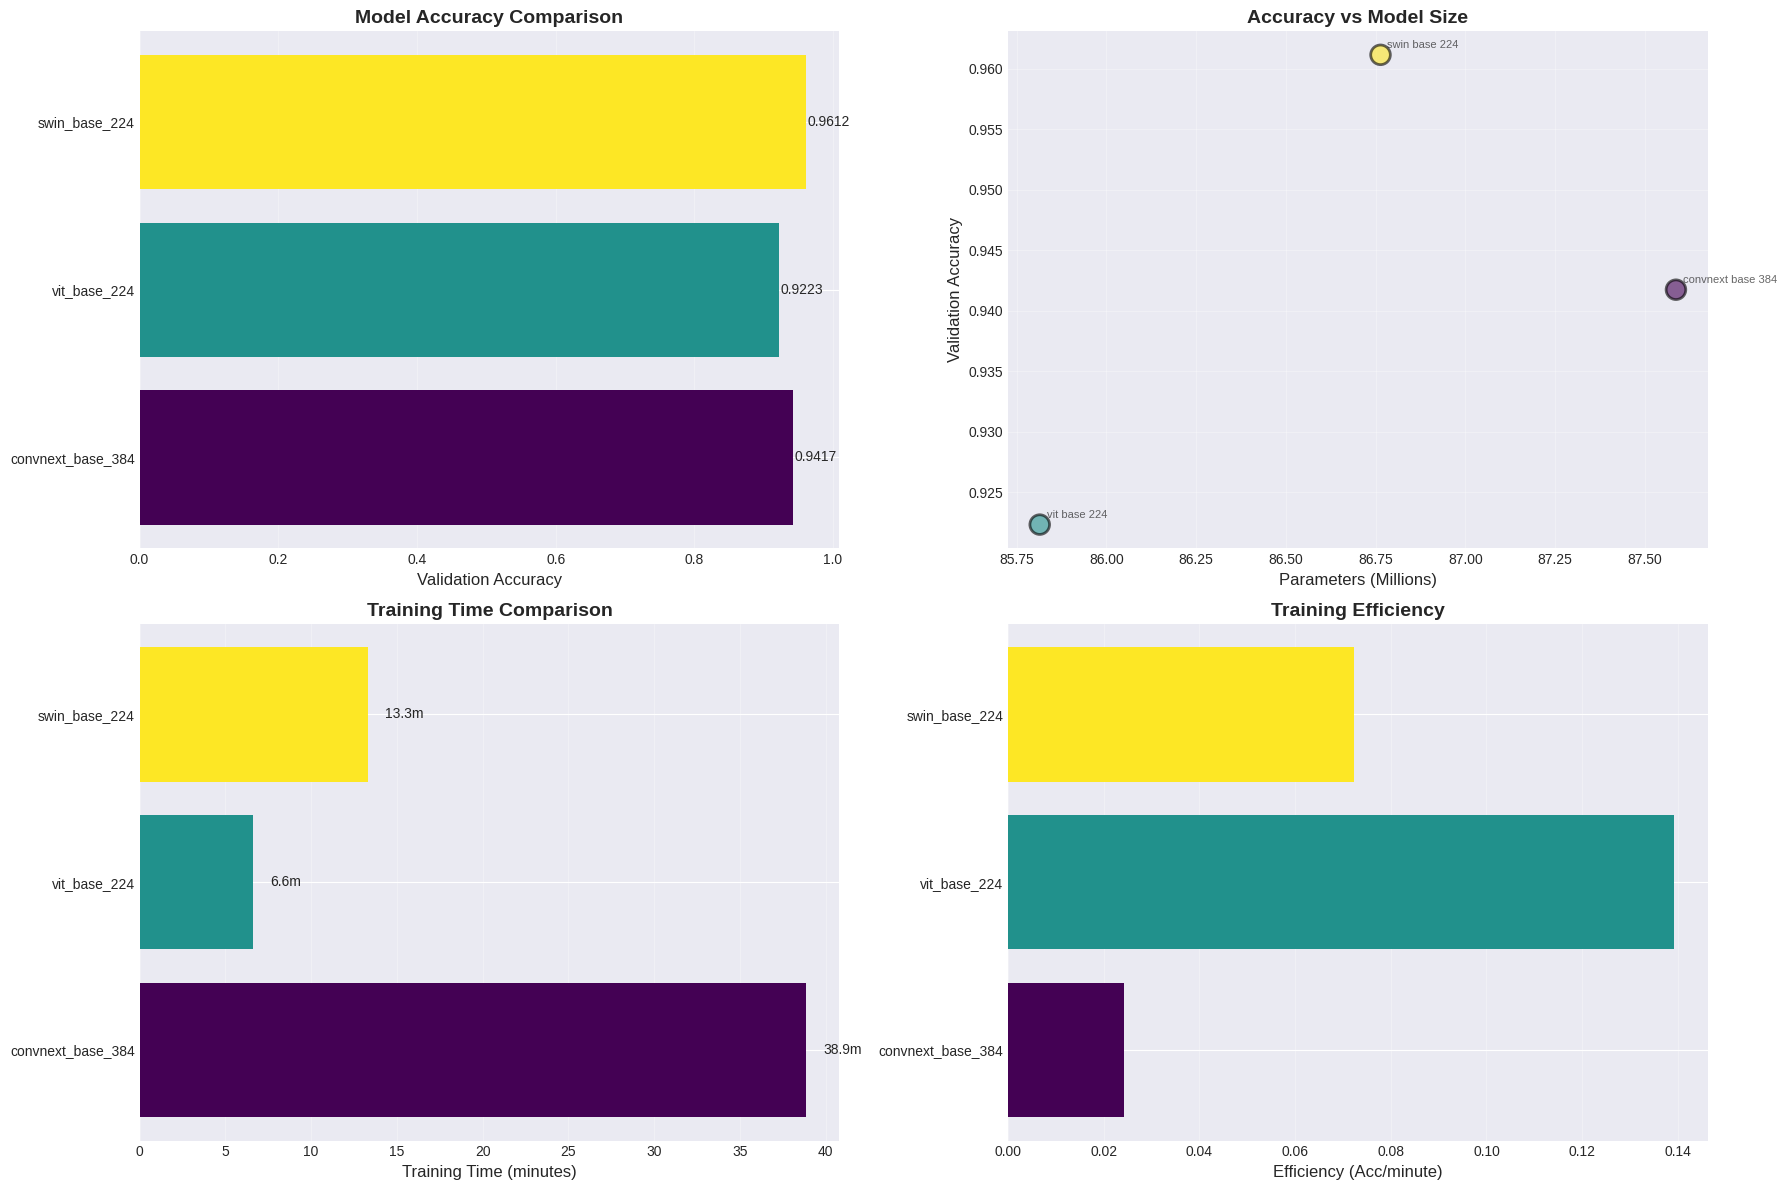

✓ Comparison visualizations saved


In [18]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Accuracy comparison
model_names = [r['name'] for r in all_results]
accuracies = [r['best_val_acc'] for r in all_results]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

y_pos = np.arange(len(model_names))
axes[0, 0].barh(y_pos, accuracies, color=colors)
axes[0, 0].set_yticks(y_pos)
axes[0, 0].set_yticklabels(model_names)
axes[0, 0].set_xlabel('Validation Accuracy', fontsize=12)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(accuracies):
    axes[0, 0].text(v + 0.002, i, f'{v:.4f}', va='center')

# 2. Accuracy vs Parameters
params = [r['total_params']/1e6 for r in all_results]
axes[0, 1].scatter(params, accuracies, s=200, c=range(len(params)),
                  cmap='viridis', alpha=0.6, edgecolors='black', linewidth=2)

for i, name in enumerate(model_names):
    axes[0, 1].annotate(
        name.replace('_', ' '),
        (params[i], accuracies[i]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.7
    )

axes[0, 1].set_xlabel('Parameters (Millions)', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Training time comparison
times = [r['total_time']/60 for r in all_results]
axes[1, 0].barh(y_pos, times, color=colors)
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(model_names)
axes[1, 0].set_xlabel('Training Time (minutes)', fontsize=12)
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(times):
    axes[1, 0].text(v + 1, i, f'{v:.1f}m', va='center')

# 4. Efficiency (Accuracy per minute)
efficiency = [acc / (t/60) for acc, t in zip(accuracies, [r['total_time'] for r in all_results])]
axes[1, 1].barh(y_pos, efficiency, color=colors)
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(model_names)
axes[1, 1].set_xlabel('Efficiency (Acc/minute)', fontsize=12)
axes[1, 1].set_title('Training Efficiency', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(CONFIG['results_dir'], 'phase2b_comparison.png'),
    dpi=150,
    bbox_inches='tight'
)
plt.show()

print('✓ Comparison visualizations saved')

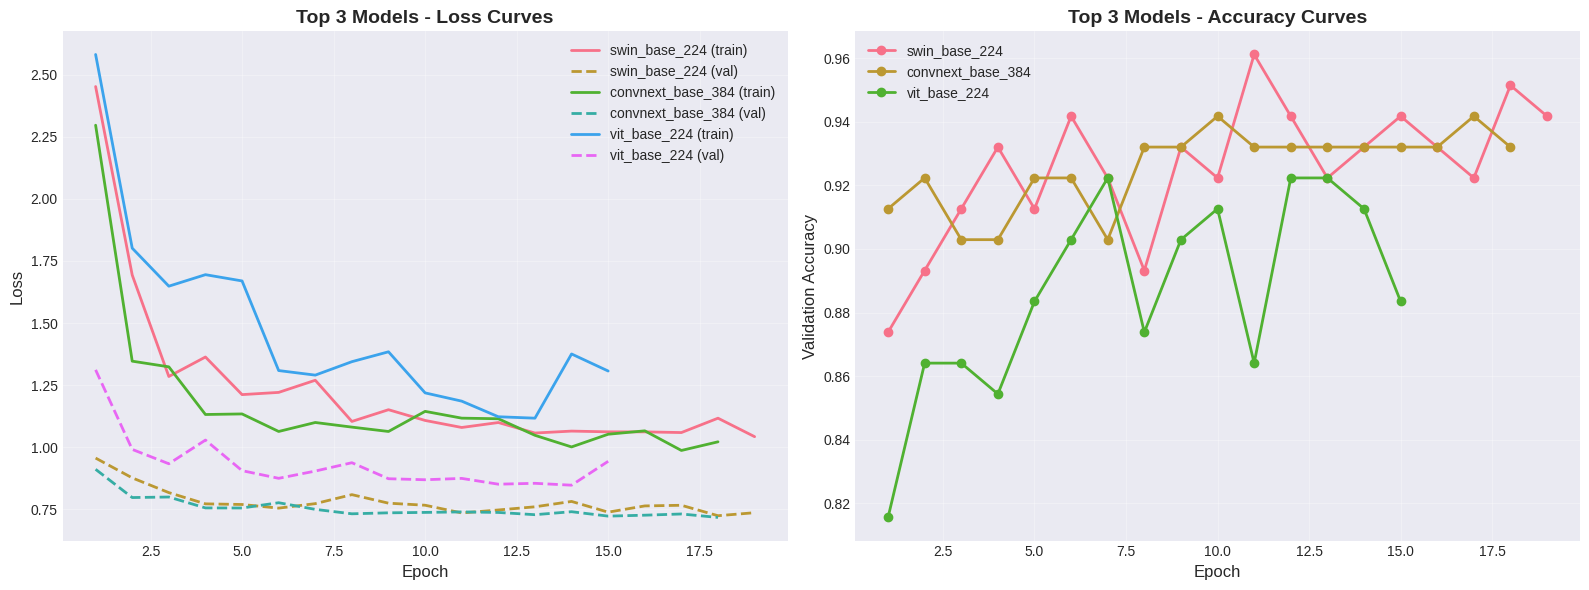

✓ Top 3 training curves saved


In [19]:
# Training curves for top 3 models
top3_results = sorted(all_results, key=lambda x: x['best_val_acc'], reverse=True)[:3]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for result in top3_results:
    epochs_range = range(1, len(result['history']['val_acc']) + 1)

    # Loss
    axes[0].plot(
        epochs_range,
        result['history']['train_loss'],
        label=f"{result['name']} (train)",
        linewidth=2
    )
    axes[0].plot(
        epochs_range,
        result['history']['val_loss'],
        label=f"{result['name']} (val)",
        linestyle='--',
        linewidth=2
    )

    # Accuracy
    axes[1].plot(
        epochs_range,
        result['history']['val_acc'],
        label=result['name'],
        marker='o',
        linewidth=2
    )

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Top 3 Models - Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('Top 3 Models - Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(CONFIG['results_dir'], 'phase2b_top3_curves.png'),
    dpi=150,
    bbox_inches='tight'
)
plt.show()

print('✓ Top 3 training curves saved')

## 8. Generate Submission from Best Model

In [20]:
def predict_with_tta(model, img_size, image, n_tta=5):
    """
    Test-time augmentation for better predictions
    """
    model.eval()

    # TTA transforms
    tta_transforms = [
        get_transforms(img_size, 'val'),  # Original
        A.Compose([A.HorizontalFlip(p=1.0)] +
                 get_transforms(img_size, 'val').transforms),
        A.Compose([A.Rotate(limit=10, p=1.0)] +
                 get_transforms(img_size, 'val').transforms),
        A.Compose([A.Rotate(limit=-10, p=1.0)] +
                 get_transforms(img_size, 'val').transforms),
        A.Compose([A.RandomBrightnessContrast(p=1.0)] +
                 get_transforms(img_size, 'val').transforms),
    ]

    predictions = []

    with torch.no_grad():
        for transform in tta_transforms[:n_tta]:
            augmented = transform(image=image)['image']
            augmented = augmented.unsqueeze(0).to(device)

            output = model(augmented)
            probs = F.softmax(output, dim=1)
            predictions.append(probs.cpu().numpy())

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred

In [21]:
# Load best model
best_model_result = max(all_results, key=lambda x: x['best_val_acc'])
best_model_name = best_model_result['name']

print(f"Loading best model: {best_model_name}")

# Find model config
best_config = None
for cfg in MODEL_CONFIGS:
    if cfg['name'] == best_model_name:
        best_config = cfg
        break

if best_config is None:
    print("Error: Could not find model config")
else:
    # Create model
    model = create_model(
        best_config['model_name'],
        num_classes=NUM_CLASSES,
        drop_path_rate=0  # No dropout for inference
    )

    # Load checkpoint
    checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], f'{best_model_name}_best.pth')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

Loading best model: swin_base_224
✓ Model loaded (Val Acc: 0.9612)


Transform ready: True
Found 400 test images
Running TTA predictions...


  0%|          | 0/400 [00:00<?, ?it/s]

✓ Saved /content/drive/MyDrive/ml_results/phase2b_results/submission_phase2b_multimodal_tta.csv
Predictions: 400
0     22
1     13
2     16
3     21
4     20
5     20
6     15
7     20
8     16
9     21
10    19
11    24
12    14
13    28
14    20
15    29
16    20
17    19
18    24
19    19
Name: count, dtype: int64


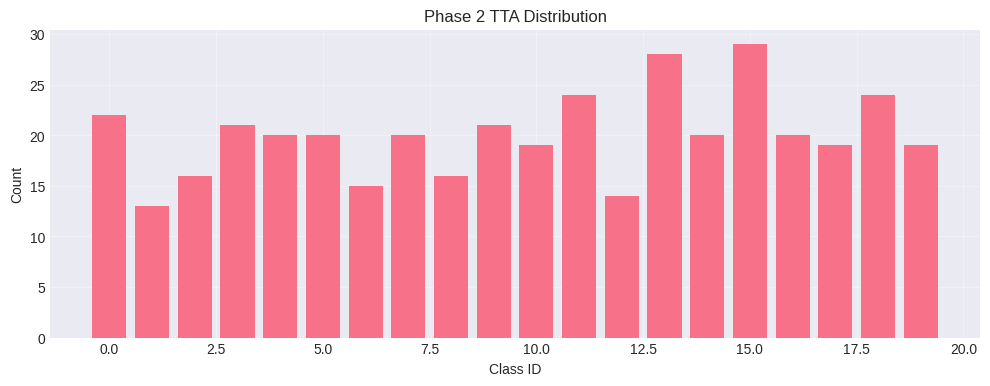

In [22]:
test_transform = get_transforms(best_config['img_size'], 'val')
print(f"Transform ready: {test_transform is not None}")

test_image_paths = []
for root, dirs, files in os.walk(CONFIG['test_images']):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths.append(os.path.join(root, file))

print(f"Found {len(test_image_paths)} test images")

# Generate predictions
predictions = []
print("Running TTA predictions...")

for img_path in tqdm(test_image_paths):
    # Safe loading matching your original
    image = cv2.imread(img_path)
    if image is None or image.size == 0:
        image = np.zeros((best_config['img_size'], best_config['img_size'], 3), dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    avg_pred = predict_with_tta(model, best_config['img_size'], image, n_tta=5)
    predictions.append(int(np.argmax(avg_pred)))

# Save submission
submission = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths],
    'class_idx': predictions
})

submission_path = os.path.join(CONFIG['results_dir'], f'submission_phase2b_multimodal_tta.csv')
submission.to_csv(submission_path, index=False)

print(f"✓ Saved {submission_path}")
print(f"Predictions: {len(predictions)}")
print(pd.Series(predictions).value_counts().sort_index())

# 5. Plot
plt.figure(figsize=(12, 4))
plt.bar(pd.Series(predictions).value_counts().sort_index().index,
        pd.Series(predictions).value_counts().sort_index().values)
plt.title('Phase 2 TTA Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase2b_tta_dist.png'), dpi=150)
plt.show()
